# Обучение алгоримов

**Бизнес-задача:** предсказание оттока клиентов
**Задача на языке машинного обучения:** бинарная классификация

**Специфика задачи:** дисбаланс классов в сторону меньшего количетва наблюдений для класса целевого (целевой класс составляет 12% от общего числа наблюдений) и разреженные данные (возможные признаки при формировании были не для всех наблюдений). 

**Подход к выбору модели:**
1. Проведение разных видов ресемплирования, выбор лучшего
2. Использование базовой модели, в которой можно также исследовать важность признаков (RandomForest) 
3. Финальное тестирование перед лидербордом проведено на независимом от ресемплирования наборе данных. 


**Результаты**: 

1. Использован простой алгоритм RandomForest
2. Выявлено наиболее устойчивый и безопасный в данной ситуации подход к ресемплированию
3. Метрика recall-score на скрытой части 0.79
4. Лучшая метрика в ходе соревнования 0.81

In [1]:
import pandas as pd
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import StratifiedKFold


#Загрузка данных
df_train = pd.read_csv('current_train.csv')
df_test = pd.read_csv('test.csv')

df_train.drop('Unnamed: 0', axis=1, inplace=True)

In [2]:
def get_train_results_and_model(model, X, y, test_size):
    
    """Функция возвращает обученную модель и
    рисует график важности признаков"""
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=2)
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    print("Recall score:", recall_score(y_test, predictions, average='macro'))
    print(classification_report(y_test, predictions))
    
    pd.DataFrame(data={'score': model.feature_importances_}, 
            index=model.feature_names_in_).sort_values(by='score').plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False)
    return model
    
   

In [3]:
#Изначальное распределение классов в наборе данных:

print('Изначальное распределение классов в наборе данных:')
print(df_train['blocked'].value_counts())

Изначальное распределение классов в наборе данных:
0    5294
1     698
Name: blocked, dtype: int64


Classic Random Forest


/var/folders/44/m5wkyqf96jjfs5d97lqgk_q00000gn/T/ipykernel_3740/1308719740.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Recall score: 0.6332288401253918
              precision    recall  f1-score   support

           0       0.67      0.78      0.72        87
           1       0.63      0.48      0.55        66

    accuracy                           0.65       153
   macro avg       0.65      0.63      0.63       153
weighted avg       0.65      0.65      0.65       153

Метрика на скрытой части
Recall score: 0.7140083632019116


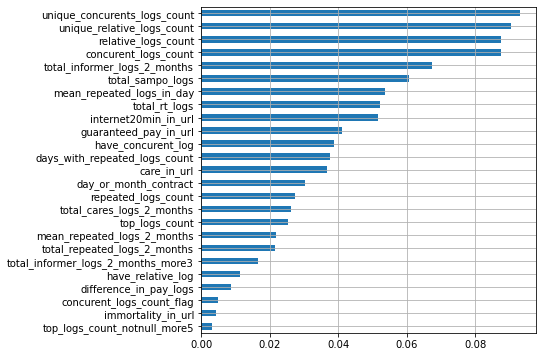

In [4]:
#Срез сэмпла для обучения алгоритма
#Необходим для устранения сильного ребаланса
df_train_sample = df_train.query('blocked==0').sample(1000, 
                 random_state=7).append(df_train.query('blocked==1')).fillna(0)

#Определение матрицы признаков и вектора целевой переменной
X = df_train_sample.drop(["contract_id", "blocked"], axis = 1)
y = df_train_sample[["blocked"]]

#Разбиение датасета так, чтобы спрятать независимый кусочек для ещё одного тестирования, помимо валидации
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

#Определение алгоритма
classic_random_forest = RandomForestClassifier(random_state=1, n_estimators=200, max_depth=11,
                             criterion="entropy")

#Обучение и оценка качества
print('Classic Random Forest')
classic_random_forest = get_train_results_and_model(classic_random_forest, X_train, y_train, 0.1)

print('Метрика на скрытой части')

predictions = classic_random_forest.predict(X_test)
print("Recall score:", recall_score(y_test, predictions, average='macro'))

В классическом варианте алгоритм хуже улавливает класс, представленный в недостатке, 1 клиент ушел. Качество предсказаний в ближении к полевой работе 0.71, среднее качество 0.67

Распределение после ресемплирования
blocked
0          1807
1          1807
dtype: int64


/var/folders/44/m5wkyqf96jjfs5d97lqgk_q00000gn/T/ipykernel_3740/1308719740.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Recall score: 0.8130507074472592
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       296
           1       0.82      0.81      0.82       319

    accuracy                           0.81       615
   macro avg       0.81      0.81      0.81       615
weighted avg       0.81      0.81      0.81       615

Метрика на скрытой части
Recall score: 0.6599152143193594


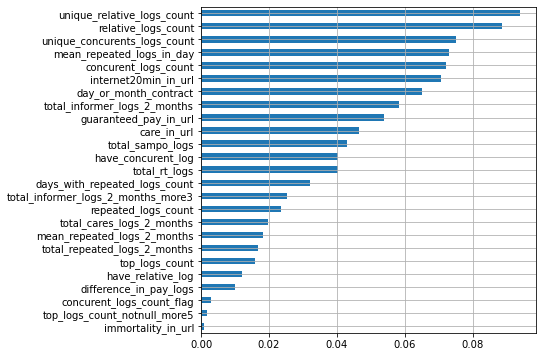

In [5]:
from imblearn.over_sampling import SVMSMOTE

#Выделение тренировочного подмножества
df_train_sample = df_train.query('blocked==0').sample(2000, 
                 random_state=8).append(df_train.query('blocked==1')).fillna(0)

#Определение матрицы признаков и вектора целевой переменной
X = df_train_sample.drop(["contract_id", "blocked"], axis = 1)
y = df_train_sample[["blocked"]]


#Разбиение датасета так, чтобы спрятать независимый кусочек для ещё одного тестирования,
# помимо валидации
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X, y, 
                                                        test_size=0.1, random_state=2)


#Определение алгоритма ресемлирования. 
# Проводится перевыборка меньшего класса
sm = SVMSMOTE(random_state=721, k_neighbors=3, m_neighbors=2, out_step=0.4)
X_up, y_up = sm.fit_resample(X_train_up, y_train_up)

print('Распределение после ресемплирования')
print(y_up.value_counts())

#Определение классификатора
clf_svm_smote = RandomForestClassifier(random_state=1, n_estimators=200,
                                       min_samples_split=2, criterion="entropy")

#Получение результатов
clf_svm_smote = get_train_results_and_model(clf_svm_smote, X_up, y_up, 0.17)

print('Метрика на скрытой части')

predictions = clf_svm_smote.predict(X_test_up)
print("Recall score:", recall_score(y_test_up, predictions, average='macro'))

На основе перевыборки наблюдений меньшего класса удается устранить скос качества, однако только на валидирующем наборе. Судя по результатам скрытой части 0.66 и среднему 0.74 для обоих метрик модель является не устойчивой для использования такого подхода в работе. 

Распределение после ресемплирования
blocked
0          712
1          636
dtype: int64


/var/folders/44/m5wkyqf96jjfs5d97lqgk_q00000gn/T/ipykernel_3740/1308719740.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Recall score: 0.7257575757575758
              precision    recall  f1-score   support

           0       0.67      0.82      0.74       110
           1       0.79      0.63      0.70       120

    accuracy                           0.72       230
   macro avg       0.73      0.73      0.72       230
weighted avg       0.73      0.72      0.72       230

Метрика на скрытой части
Recall score: 0.7044504181600956


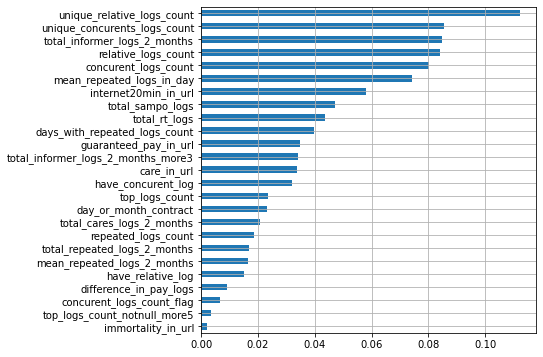

In [6]:
#downsampling majority 

from imblearn.under_sampling import EditedNearestNeighbours
import numpy as np

#Выделение тренировочного подмножества
df_train_sample = df_train.query('blocked==0').sample(1000, 
                 random_state=9).append(df_train.query('blocked==1')).fillna(0)

#Определение матрицы признаков и вектора целевой переменной
X = df_train_sample.drop(["contract_id", "blocked"], axis = 1)
y = df_train_sample[["blocked"]]

#Разбиение датасета так, чтобы спрятать независимый кусочек 
#для ещё одного тестирования, помимо валидации
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X, y, 
                                                        test_size=0.1, random_state=2)


#Проведение ресемплирования
#Проводится снижение количества наблюдений избыточного класса
nn = EditedNearestNeighbours(sampling_strategy='not minority', kind_sel='mode') #random_state=12
X_down, y_down = nn.fit_resample(X_train_down, y_train_down)

print('Распределение после ресемплирования')
print(y_down.value_counts())

#Определение классификатора
clf_nn = RandomForestClassifier(random_state=1, n_estimators=200,
                                                   max_depth=9, criterion="entropy")

#Получение результатов
clf_nn = get_train_results_and_model(clf_nn, X_down, y_down, 0.17)

print('Метрика на скрытой части')

predictions = clf_nn.predict(X_test_down)
print("Recall score:", recall_score(y_test_down, predictions, average='macro'))

Снижение количества наблюдений мажоритарного класса проявляет себя как более устойчивое на основе текущих признаков со средним качеством на скрытом и валидационном наборах 0.71 (recall score). С таким качеством данный алгоритм более безопасно внедрять в постоянное использование. 

### Лучшая модель

Распределение после ресемплирования
blocked
0          1929
1          1929
dtype: int64


/var/folders/44/m5wkyqf96jjfs5d97lqgk_q00000gn/T/ipykernel_3740/1308719740.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Recall score: 0.7913690476190476
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       320
           1       0.85      0.72      0.78       336

    accuracy                           0.79       656
   macro avg       0.80      0.79      0.79       656
weighted avg       0.80      0.79      0.79       656

Метрика на скрытой части
Recall score: 0.7992831541218638


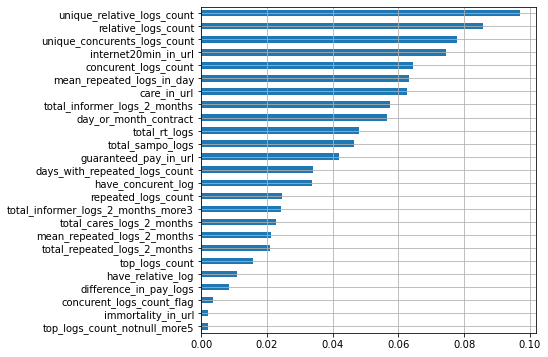

In [7]:
#downsampling + upsampling
#Выделение тренировочного подмножества

df_train_sample = df_train.query('blocked==0').sample(2150, 
                 random_state=11).append(df_train.query('blocked==1')).fillna(0)

#Определение матрицы признаков и вектора целевой переменной
X = df_train_sample.drop(["contract_id", "blocked"], axis = 1)
y = df_train_sample[["blocked"]]


#Разбиение датасета так, чтобы спрятать независимый кусочек 
# для ещё одного тестирования, помимо валидации
X_train_updown, X_test_updown, y_train_updown, y_test_updown = train_test_split(X, y, 
                                                        test_size=0.1, random_state=2)


#Проведение ресемплирования
#Проводится персмотр количества наблюдений для всего набора данных
smt = SMOTETomek(random_state=7, sampling_strategy='minority')
X_updown, y_updown = smt.fit_resample(X_train_updown, y_train_updown)

print('Распределение после ресемплирования')
print(y_updown.value_counts())

#Определение классификатора
clf_smote_tomek = RandomForestClassifier(random_state=1, n_estimators=200,
                                         criterion="entropy")

#Получение результатов
clf_smote_tomek = get_train_results_and_model(clf_smote_tomek, X_updown, y_updown, 0.17)

print('Метрика на скрытой части')

predictions = clf_smote_tomek.predict(X_test_down)
print("Recall score:", recall_score(y_test_down, predictions, average='macro'))

Ресемплирование обоих классов, как и снижение количества наблюдений класса мажоритарного устойчиво к независимому тестированию.Среднее качество среди двух метрик 0.795 (recall score), лучший результат — 0.81 по публичному лидерборду (с лучшей комбинацией признаков, которую я, по неопытности, не сохранила, повод быть оптытнее и расти)

In [8]:
ffinal_test_data = df_test[['have_concurent_log',
 'unique_concurents_logs_count',
 'concurent_logs_count',
 'concurent_logs_count_flag',
 'total_sampo_logs',
 'total_rt_logs',
 'top_logs_count',
# 'top_logs_count_notnull_more5',
 'day_or_month_contract',
 'unique_relative_logs_count',
 'have_relative_log',
 'relative_logs_count',
# 'immortality_in_url',
 'care_in_url',
 'internet20min_in_url',
 'guaranteed_pay_in_url',
 'total_cares_logs_2_months',
 'total_informer_logs_2_months',
 'total_informer_logs_2_months_more3',
 'difference_in_pay_logs',
 'mean_repeated_logs_2_months',
 'total_repeated_logs_2_months',
 'repeated_logs_count',
 'days_with_repeated_logs_count',
 'mean_repeated_logs_in_day'
                                   ]]

df_train_test = df_train[['contract_id',
 'blocked',
 'have_concurent_log',
 'unique_concurents_logs_count',
 'concurent_logs_count',
 'concurent_logs_count_flag',
 'total_sampo_logs',
 'total_rt_logs',
 'top_logs_count',
# 'top_logs_count_notnull_more5',
 'day_or_month_contract',
 'unique_relative_logs_count',
 'have_relative_log',
 'relative_logs_count',
# 'immortality_in_url',
 'care_in_url',
 'internet20min_in_url',
 'guaranteed_pay_in_url',
  'total_cares_logs_2_months',
 'total_informer_logs_2_months',
 'total_informer_logs_2_months_more3',
 'difference_in_pay_logs',
 'mean_repeated_logs_2_months',
 'total_repeated_logs_2_months',
 'repeated_logs_count',
 'days_with_repeated_logs_count',
 'mean_repeated_logs_in_day'
                         ]]